## Bayesian Network Modeling

In [32]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pandas as pd
import itertools
from math import log2
import matplotlib.pyplot as plt
import numpy as np

In [33]:
data = pd.read_csv("filtered_sequences-v1.csv")

In [3]:
data

,Sequence ID,Failure Mode,Q1,Q2,Q3,Q4,Q5,Q6,Total Duration,Sequence
0,1,LH need to be step initialized,No,Yes,-,-,-,-,25,Q1 > Q2
1,2,System hickup,No,No,No,Yes,-,-,60,Q1 > Q2 > Q3 > Q4
2,3,LH board problem,Yes,-,-,-,-,-,15,Q1
3,4,2DIB connection or IMCR communication NOK,No,No,Yes,-,-,-,40,Q1 > Q2 > Q3
4,5,Broken PSU,No,No,No,No,Yes,-,90,Q1 > Q2 > Q3 > Q4 > Q5
5,6,2DIB connection or IMCR communication NOK,No,No,Yes,-,-,-,40,Q1 > Q2 > Q3
6,7,LH need to be step initialized,No,Yes,-,-,-,-,25,Q1 > Q2
7,8,LH board problem,Yes,-,-,-,-,-,15,Q1
8,9,System hickup,No,No,No,Yes,-,-,60,Q1 > Q2 > Q3 > Q4
9,10,System hickup,No,No,No,Yes,-,-,60,Q1 > Q2 > Q3 > Q4


In [4]:
# Count occurrences of each failure mode
failure_mode_counts = data["Failure Mode"].value_counts().reset_index()
failure_mode_counts.columns = ["Failure Mode", "Occurrences"]

In [5]:
failure_mode_counts

,Failure Mode,Occurrences
0,LH board problem,12
1,LH need to be step initialized,9
2,2DIB connection or IMCR communication NOK,9
3,System hickup,6
4,Broken PSU,1


In [6]:
# Count occurrences of each question with "Yes" answers only
question_yes_counts = {}
for q in ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6"]:
    yes_count = data[q].value_counts().get("Yes", 0)
    question_yes_counts[q] = yes_count

question_yes_counts_df = pd.DataFrame(list(question_yes_counts.items()), columns=["Question", "Yes"])
print(question_yes_counts_df)


  Question  Yes
0       Q1   12
1       Q2    8
2       Q3    9
3       Q4    6
4       Q5    1
5       Q6    0


In [34]:
# Define the Bayesian Network
bn = gum.BayesNet('DiagnosticNetwork')

# Define questions
questions = {
    "Q1": "Does LH driver initialize after a reboot of the LH board?",
    "Q2": "Do step initialize LH solve the issue?",
    "Q3": "Did reconnect 2DIB power cable or rebooting the IMCR solve the problem?",
    "Q4": "Did restart solve the problem?",
    "Q5": "Are there any LED's on the PSUs in the IMCR rack red or not burning at all?",
    "Q6": "Are there any red and/or blinking LEDs on the 2DIB?"
}

# Add question nodes to the network
for q_id, q_name in questions.items():
    bn.add(gum.LabelizedVariable(q_id, q_name, 2))  # 2 states: Yes/No

# Define failure modes
failure_modes = [
    "LHBoardProblem",
    "LHNeedToBeStepInitialized",
    "2DIBConnectionOrIMCRCommNOK",
    "SystemHickup",
    "BrokenPSU",
    "Broken2DIBBox",
    "PossibleDamagedCablesIMCRandFlexwave"
]

# Add the FailureMode node
bn.add(gum.LabelizedVariable("FailureMode", "Failure Mode", failure_modes))

# Add arcs from questions to FailureMode
for q_id in questions.keys():
    bn.addArc(q_id, "FailureMode")

# Assign Prior Probabilities for Questions
question_priors = {
    "Q1": [0.4, 0.6],
    "Q2": [0.6, 0.4],
    "Q3": [0.5, 0.5],
    "Q4": [0.7, 0.3],
    "Q5": [0.9, 0.1],
    "Q6": [1.0, 0.0]
}

for q_id, prior in question_priors.items():
    bn.cpt(q_id).fillWith(prior)

# Define CPT for FailureMode using historical data
historical_data = {
    "LHBoardProblem": 0.324,
    "LHNeedToBeStepInitialized": 0.243,
    "2DIBConnectionOrIMCRCommNOK": 0.243,
    "SystemHickup": 0.162,
    "BrokenPSU": 0.027,
    "Broken2DIBBox": 0.0,
    "PossibleDamagedCablesIMCRandFlexwave": 0.0
}

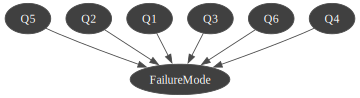

In [35]:
gnb.showBN(bn)

In [36]:
failure_mode_cpt = bn.cpt("FailureMode")

for evidence_dict in itertools.product([0, 1], repeat=len(questions)):
    evidence_dict = dict(zip(questions.keys(), evidence_dict))
    yes_count = sum(evidence_dict.values())
    if yes_count == 1:  # Only one "Yes" allowed
        yes_question = [q for q, v in evidence_dict.items() if v == 1][0]
        probabilities = [historical_data.get(fm, 0) if fm == failure_modes[list(questions.keys()).index(yes_question)] else 0
                         for fm in failure_modes]
    else:  # No "Yes" or multiple "Yes" are invalid
        probabilities = [0] * len(failure_modes)
    failure_mode_cpt[evidence_dict] = probabilities

# Define entropy function
def entropy(prob):
    # Calculate entropy of a probability distribution
    if not prob or sum(prob) == 0:
        return 0
    return -sum(p * log2(p) for p in prob if p > 0)

# Define function to calculate IG
def calculate_information_gain(bn, ie, question, target="FailureMode"):
    try:
        prior_entropy = entropy(ie.posterior(target).tolist())
        # Posterior Entropy for Yes
        ie.setEvidence({question: 1})
        posterior_yes = entropy(ie.posterior(target).tolist())
        ie.eraseEvidence(question)
        # Posterior Entropy for No
        ie.setEvidence({question: 0})
        posterior_no = entropy(ie.posterior(target).tolist())
        ie.eraseEvidence(question)
        # Weighted Posterior Entropy
        p_yes = bn.cpt(question)[1]  # P(Yes)
        p_no = 1 - p_yes  # P(No)
        posterior_entropy = p_yes * posterior_yes + p_no * posterior_no
        # Information Gain results
        return prior_entropy - posterior_entropy
    except Exception as e:
        print(f"Error with {question}: {e}")
        return 0

In [37]:
# Initialize the inference engine
ie = gum.LazyPropagation(bn)

# Define question costs
question_costs = {"Q1": 15, 
                  "Q2": 10, 
                  "Q3": 15, 
                  "Q4": 20, 
                  "Q5": 30, 
                  "Q6": 45}

# Count "Yes" answers from historical data
question_yes_counts = {"Q1": 12, 
                       "Q2": 8, 
                       "Q3": 9, 
                       "Q4": 6, 
                       "Q5": 1, 
                       "Q6": 0}

total_resolutions = sum(question_yes_counts.values())

smoothing_factor = 0.01

question_weights = {q: (count + smoothing_factor) / (total_resolutions + len(question_yes_counts) * smoothing_factor)
                    for q, count in question_yes_counts.items()}

# Simulate the process
# Set Q4 to simulate a "Yes" answer
simulated_answers = {"Q1": 0, "Q2": 0, "Q3": 0, "Q4": 1, "Q5": 0, "Q6": 0}

current_evidence = {}
asked_questions = []

# Compute initial entropy
initial_entropy = entropy(ie.posterior("FailureMode").tolist())
print(f"\n🟢 Initial Entropy: {initial_entropy:.4f}")

while True:
    remaining_questions = [q for q in question_costs if q not in asked_questions]
    if not remaining_questions:
        break

    question_metrics = {}

    for q in remaining_questions:
        try:
            ig = calculate_information_gain(bn, ie, q, "FailureMode")

            # Dynamic entropy calculation
            ie.setEvidence({q: 1})
            posterior_yes_entropy = entropy(ie.posterior("FailureMode").tolist())
            ie.eraseEvidence(q)

            ie.setEvidence({q: 0})
            posterior_no_entropy = entropy(ie.posterior("FailureMode").tolist())
            ie.eraseEvidence(q)

            p_yes = bn.cpt(q)[1]
            p_no = 1 - p_yes
            posterior_entropy = p_yes * posterior_yes_entropy + p_no * posterior_no_entropy

            # Evidence alignment boost
            evidence_boost = 2 if simulated_answers[q] == 1 else 1
            cost = question_costs[q]
            weight = question_weights[q]
            utility = evidence_boost * (ig / cost) * weight if cost > 0 and weight > 0 else 0

            question_metrics[q] = {
                "utility": utility,
                "ig": ig,
                "cost": cost,
                "weight": weight,
                "entropy": posterior_entropy,
            }
        except Exception as e:
            print(f"Error with {q}: {e}")
            question_metrics[q] = {
                "utility": 0,
                "ig": 0,
                "cost": question_costs[q],
                "weight": question_weights[q],
                "entropy": float('inf'),
            }

    # Debugging printout for metrics
    print("\n **Evaluating Questions**:")
    for q, metrics in sorted(question_metrics.items(), key=lambda x: -x[1]["utility"]):
        print(
            f"  - {q}: Utility={metrics['utility']:.4f}, IG={metrics['ig']:.4f}, "
            f"Cost={metrics['cost']}, Weight={metrics['weight']:.4f}, Entropy={metrics['entropy']:.4f}"
        )

    # # Select the best question based on utility
    # best_question = max(question_metrics, key=lambda x: question_metrics[x]["utility"])
    # print(f"\n✅ **Selected Question: {best_question}**")
    
    # Select the best question based on utility and include fallback mechanism
    if all(metrics["utility"] == 0 for metrics in question_metrics.values()):
        print("\n⚠️ No valid information gain, falling back to weight-to-cost ratio.")
        best_question = max(remaining_questions, key=lambda q: question_weights[q] / question_costs[q])
        print(f"✅ **Fallback Selected Question: {best_question} (Weight-to-Cost Ratio)**")
    else:
        best_question = max(question_metrics, key=lambda x: question_metrics[x]["utility"])
        print(f"\n✅ **Selected Question: {best_question}**")


    # Update evidence
    asked_questions.append(best_question)
    current_evidence[best_question] = simulated_answers[best_question]

    # Set evidence for selected question
    try:
        ie.setEvidence(current_evidence)
        current_entropy = entropy(ie.posterior("FailureMode").tolist())
        print(f"🔵 Entropy After {best_question}: {current_entropy:.4f}")
    except Exception as e:
        print(f"❌ Error setting evidence for {best_question}: {e}")
        break

    # Stop if entropy is sufficiently low
    if current_entropy < 0.05:
        break

print("\n🚀 Optimized Question Sequence:", asked_questions)


🟢 Initial Entropy: 1.7311
Error with Q6: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)
Error with Q6: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Bayes net are incompatible (their joint proba = 0)

 **Evaluating Questions**:
  - Q1: Utility=0.0253, IG=1.1409, Cost=15, Weight=0.3331, Entropy=0.5902
  - Q2: Utility=0.0212, IG=0.9538, Cost=10, Weight=0.2221, Entropy=0.7773
  - Q3: Utility=0.0186, IG=1.1184, Cost=15, Weight=0.2499, Entropy=0.6127
  - Q4: Utility=0.0118, IG=0.7070, Cost=20, Weight=0.1667, Entropy=1.0241
  - Q5: Utility=0.0002, IG=0.1957, Cost=30, Weight=0.0280, Entropy=1.5354
  - Q6: Utility=0.0000, IG=0.0000, Cost=45, Weight=0.0003, Entropy=inf

✅ **Selected Question: Q1**
🔵 Entropy After Q1: 1.4755
Error with Q6: [pyAgrum] Several evidence/CPT are incompatible together (proba=0): some evidence entered into the Baye

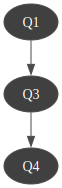

In [38]:
# Visualize question sequence
sequence_bn = gum.BayesNet('QuestionSequence')
for q in asked_questions:
    sequence_bn.add(gum.LabelizedVariable(q, questions[q], 2))
for i in range(len(asked_questions) - 1):
    sequence_bn.addArc(asked_questions[i], asked_questions[i + 1])

gnb.showBN(sequence_bn)

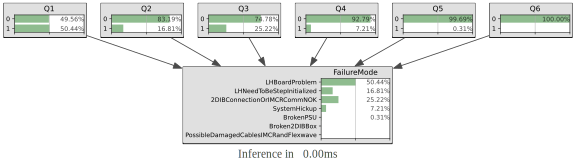

In [12]:
gnb.showInference(bn)

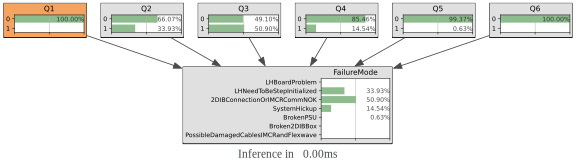

In [18]:
gnb.showInference(bn, evs={"Q1": 0})

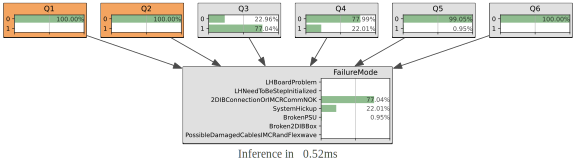

In [19]:
gnb.showInference(bn, evs={"Q1": 0, "Q2": 0})

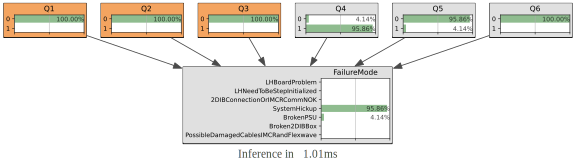

In [21]:
gnb.showInference(bn, evs={"Q1": 0, "Q2": 0, "Q3":0})

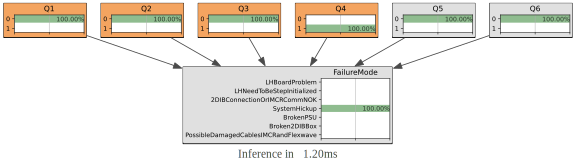

In [20]:
gnb.showInference(bn, evs={"Q1": 0, "Q2": 0, "Q3": 0, "Q4": 1})

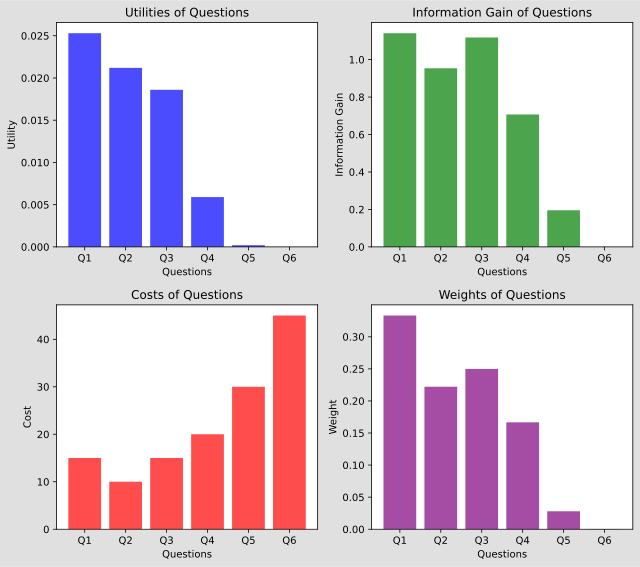

In [ ]:
# Data for the metrics
questions = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']
utilities = [0.0253, 0.0212, 0.0186, 0.0059, 0.0002, 0.0]
information_gain = [1.1409, 0.9538, 1.1184, 0.7070, 0.1957, 0.0]
costs = [15, 10, 15, 20, 30, 45]
weights = [0.3331, 0.2221, 0.2499, 0.1667, 0.0280, 0.0003]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(9, 8))

# Utility
axs[0, 0].bar(questions, utilities, color='blue', alpha=0.7)
axs[0, 0].set_title('Utilities of Questions')
axs[0, 0].set_ylabel('Utility')
axs[0, 0].set_xlabel('Questions')

# Information Gain
axs[0, 1].bar(questions, information_gain, color='green', alpha=0.7)
axs[0, 1].set_title('Information Gain of Questions')
axs[0, 1].set_ylabel('Information Gain')
axs[0, 1].set_xlabel('Questions')

# Costs
axs[1, 0].bar(questions, costs, color='red', alpha=0.7)
axs[1, 0].set_title('Costs of Questions')
axs[1, 0].set_ylabel('Cost')
axs[1, 0].set_xlabel('Questions')

# Weights
axs[1, 1].bar(questions, weights, color='purple', alpha=0.7)
axs[1, 1].set_title('Weights of Questions')
axs[1, 1].set_ylabel('Weight')
axs[1, 1].set_xlabel('Questions')

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
# Using the optimized sequence from the code
optimized_sequence = ['Q1', 'Q3', 'Q4']
question_costs = {"Q1": 15, "Q3": 15, "Q4": 20}  

# Calculate total time for optimized sequence
optimized_time = sum([question_costs[q] for q in optimized_sequence])
optimized_questions = len(optimized_sequence)

print(f"Optimized Time: {optimized_time} minutes")
print(f"Questions in Optimized Sequence: {optimized_questions}")

Optimized Time: 50 minutes
Questions in Optimized Sequence: 3


In [39]:
# Define the data for the sequences and failure modes
data = [
    {"Sequence ID": 1, "Failure Mode": "LH Need to Be Step Initialized",
     "Initial Sequence (Time)": 25, "Initial Sequence (Path)": "Q1 > Q2",
     "Optimized Sequence (Time)": 25, "Optimized Sequence (Path)": "Q1 > Q2"},
    
    {"Sequence ID": 2, "Failure Mode": "System Hickup",
     "Initial Sequence (Time)": 60, "Initial Sequence (Path)": "Q1 > Q2 > Q3 > Q4",
     "Optimized Sequence (Time)": 60, "Optimized Sequence (Path)": "Q1 > Q3 > Q4"},
    
    {"Sequence ID": 3, "Failure Mode": "LH Board Problem",
     "Initial Sequence (Time)": 15, "Initial Sequence (Path)": "Q1",
     "Optimized Sequence (Time)": 15, "Optimized Sequence (Path)": "Q1"},
    
    {"Sequence ID": 4, "Failure Mode": "2DIB Connection or IMCR Communication NOK",
     "Initial Sequence (Time)": 40, "Initial Sequence (Path)": "Q1 > Q2 > Q3",
     "Optimized Sequence (Time)": 40, "Optimized Sequence (Path)": "Q1 > Q3"}
]

# Convert the data into a pandas DataFrame
df_comparison = pd.DataFrame(data)

df_comparison


,Sequence ID,Failure Mode,Initial Sequence (Time),Initial Sequence (Path),Optimized Sequence (Time),Optimized Sequence (Path)
0,1,LH Need to Be Step Initialized,25,Q1 > Q2,25,Q1 > Q2
1,2,System Hickup,60,Q1 > Q2 > Q3 > Q4,60,Q1 > Q3 > Q4
2,3,LH Board Problem,15,Q1,15,Q1
3,4,2DIB Connection or IMCR Communication NOK,40,Q1 > Q2 > Q3,40,Q1 > Q3
